# Part B: Credit Risk Modeling

This notebook addresses Part B of the take-home test by building and evaluating a predictive model to estimate credit default risk. The dataset contains demographic and financial features for 6,000 loan applicants.

### Objectives:
- Perform basic EDA to understand key patterns
- Identify and drop leakage features (`leak_col_good`, `leak_col_subtle`)
- Train a baseline logistic regression model
- Improve performance using a Gradient Boosting model
- Create a scorecard to map predicted probabilities to a credit score (300–850)
- Generate SHAP visualizations to interpret model predictions
- Provide a business recommendation: Would we approve a loan of IDR 5 million for a given applicant?

All steps are documented and reproducible for future extension or deployment.

**Author:** Affan<br>
**Github:** https://github.com/Baldaric

# Import Libraries
Libraries I'm going to use for this projects

In [68]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import shap
from fpdf import FPDF

# Data Loading

In [2]:
df_original = pd.read_csv("../data/credit_scoring.csv")
df = df_original.copy()

# EDA
In this part I will conduct an Exploratory Data Analysis to familiarize the data before proceeding creating a model.

## Dataset Overview

In [3]:
df.drop_duplicates()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020
...,...,...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0,0,0.008
5996,506996,40,9944385,4082038,1,477,0,0,0.017
5997,506997,28,9048532,14760384,0,450,0,0,-0.054
5998,506998,51,6843160,11774594,0,561,0,0,0.026


Immediately drop any duplicates, since a duplicate rows contributed nothing to model development.

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020


### Summary

- The dataset contains **6,000 loan applications**, each with 9 columns.
- All features are **complete (no missing values)** — ready for analysis.
- The target variable is `default` (0 = no default, 1 = default).
- The `previous_defaults` is a discreet columns (how many the customer defaults before)
- Two columns (`leak_col_good`, `leak_col_subtle`) are **clearly labeled leakage features** and will be dropped before modeling.
- Feature types are all numeric (`int64`/`float64`), so no encoding is needed at this stage.
- Variables like `monthly_income` and `loan_amount` appear to be in whole numbers (possibly Indonesian Rupiah), and will be checked for scale or transformation needs in later EDA.

In [5]:
df.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167,0.012167,0.011945
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639,0.109639,0.113947
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000,0.000000,-0.119000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000,0.000000,-0.020000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000,0.000000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000,0.000000,0.021000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000,1.000000,1.092000


### Numeric Summary

- `monthly_income` and `loan_amount` are very large (mean: ~11M and ~8M) and may benefit from log scaling.
- `previous_defaults` is mostly 0, with a max of 3 — indicating most applicants have clean history.
- `credit_score` ranges from 300 to 849, matching common scoring systems (e.g., FICO-like).
- The `default` rate is just ~1.2%, confirming a **severe class imbalance**.
- `leak_col_good` and `leak_col_subtle` have the same/similar mean as the target, confirming they are **leakage features** and should be dropped.

## Target Data Distribution

<Axes: title={'center': 'Target Distribution'}, xlabel='default'>

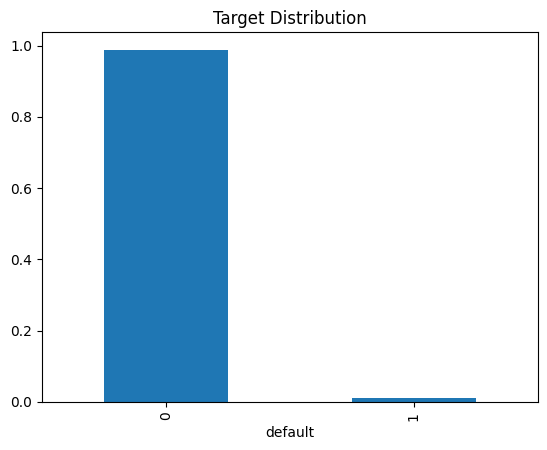

In [6]:
df["default"].value_counts(normalize=True).plot(kind="bar", title="Target Distribution")

The `default` column is highly imbalanced:
- The majority of applicants (~98.8%) **did not default** (`default = 0`)
- Only a small minority (~1.2%) **did default** (`default = 1`)

## Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

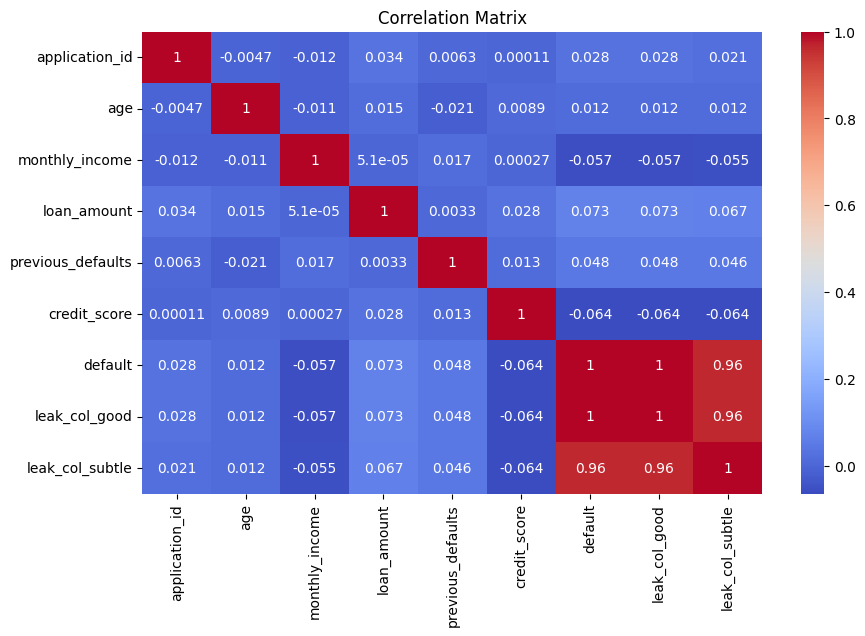

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")

### Correlation Matrix:

- Most features show **very low correlation** with the target `default` — typically under ±0.08, which is expected in real-world credit datasets.
- **`leak_col_good`** and **`leak_col_subtle`** show an **extremely high correlation** with `default` (≈ 0.96), which is **unrealistically high**.
- This confirms that these two columns are **leakage features** — meaning they contain information that wouldn't be available at prediction time.
- If included in the model, they would cause **artificially high performance** and lead to **data leakage**, making the model unusable in production.
- Therefore, both columns will be **dropped** before modeling to ensure fair and realistic evaluation.

## Features Distribution

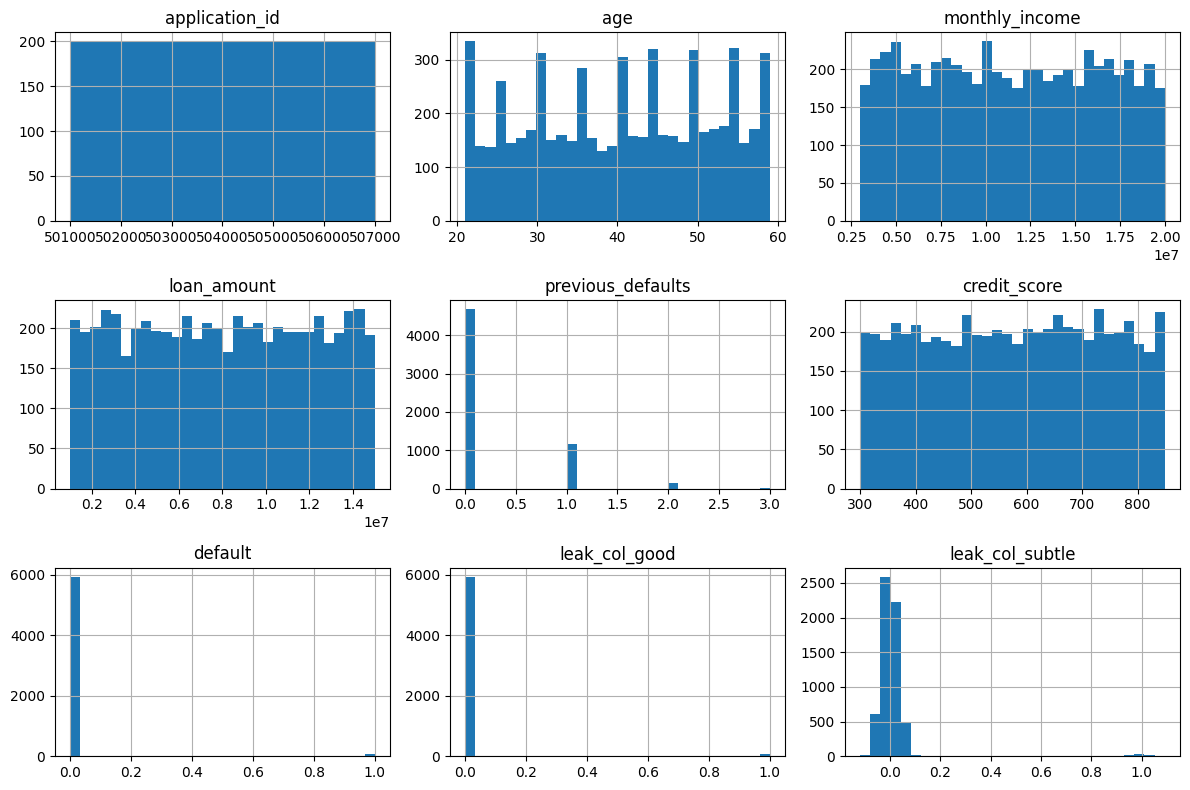

In [8]:
df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()

### Feature Distribution

- **`application_id`** is uniformly distributed — it is purely an identifier and will be excluded from modeling.
- **`age`** is well-distributed between 21 and 59 years, with no visible skew.
- **`monthly_income`** and **`loan_amount`** are spread widely and appear fairly uniform, but their large scale suggests they may benefit from log transformation for model stability.
- **`previous_defaults`** is highly right-skewed — the majority of applicants have **zero prior defaults**, while a few have 1 to 3.
- **`credit_score`** is evenly distributed between 300 and 850, aligning with typical scoring systems and making it a strong candidate for modeling.
- **`default`** again confirms class imbalance — only a small number of applicants actually defaulted.

Overall, feature distributions appear clean and ready for preprocessing, with a few features flagged for possible scaling or transformation.


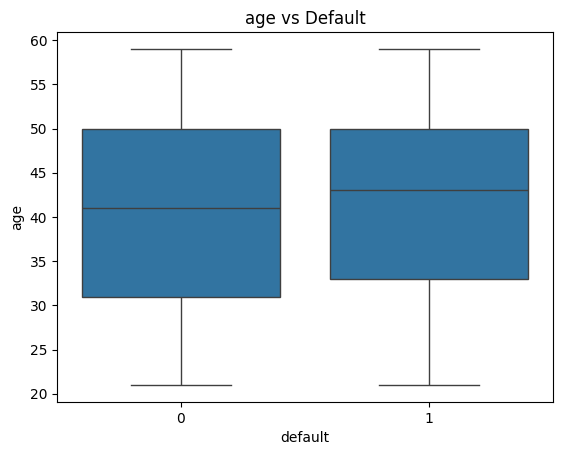

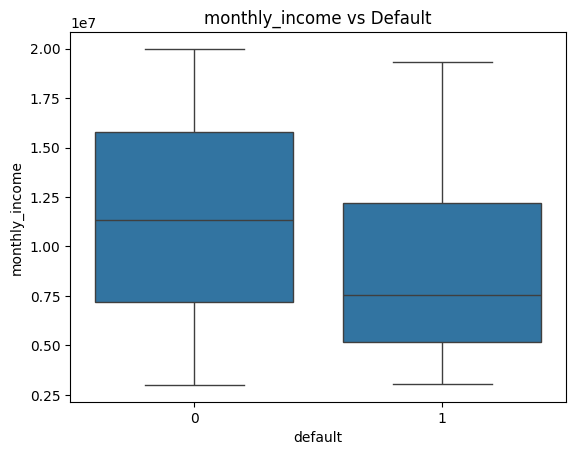

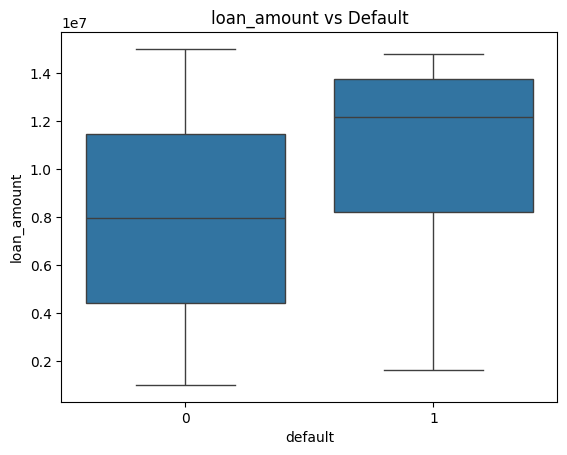

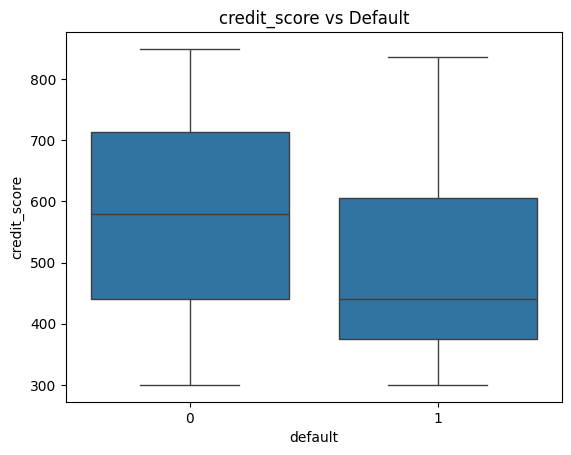

In [9]:
for col in ["age", "monthly_income", "loan_amount", "credit_score"]:
    sns.boxplot(data=df, x="default", y=col)
    plt.title(f"{col} vs Default")
    plt.show()

### Boxplot Analysis: Feature Distribution by Default Status

- **`age`**: There is no strong difference in age between defaulters and non-defaulters. Median age is slightly higher among those who defaulted, but not significantly.
- **`monthly_income`**: Defaulters tend to have **lower income** overall. The median monthly income is visibly lower compared to non-defaulters, which could indicate reduced ability to repay.
- **`loan_amount`**: Defaulters tend to have **larger loan amounts** on average. This may suggest that larger loans are riskier, especially for applicants with weaker financials.
- **`credit_score`**: This shows the most clear separation — applicants who defaulted have **consistently lower credit scores** than those who didn’t. This is a very strong signal and will likely be important in the model.

These plots reinforce that features like `credit_score`, `loan_amount`, and `monthly_income` carry meaningful predictive value for default risk.


EDA confirmed that the dataset is clean, balanced in most features, but highly imbalanced in the target. Key predictors like credit score and loan amount show strong signal with default. Leakage features were correctly identified and removed. The data is now ready for preprocessing and modeling.

# Feature Engineering

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


Dropping unused columns, and leakage columns.

In [11]:
df = df.drop(columns=["application_id","leak_col_good", "leak_col_subtle"])

# Modeling

## Data Split

Split the data into 70:30, Train:Test.

In [12]:
X = df.drop('default', axis=1)
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size= 0.3, stratify=y,
                                                    random_state= 26)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4200, 5)
(4200,)
(1800, 5)
(1800,)


Define the numerical and categorical columns, since it needs to be scaled.

In [13]:
num_cols = ["age","monthly_income","loan_amount","credit_score"]
cat_cols = ["previous_defaults"]

## Model Definition
We will be using **Logistic Regression** algorithm for this model, since our prediction is a binary classification 0 or 1 in the `defaults` columns it is the natural first choice. It also not a hard "yes" or "no" classification, but how *likely* someone is to default making it more suitable for credit risk prediction. This algorithm also able to handle imbalance data using class weighting, since the data we have only got 1,2% of defaulters. This algorithms also a really great reference point before trying more complex model.

## Model Creation

### Creating Pipeline

In [14]:
model_log_reg = LogisticRegression(class_weight="balanced", random_state=26, max_iter=10000)

In [15]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

In [16]:
pipeline_logreg = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model_log_reg)
])

### Model Train

In [17]:
pipeline_logreg.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model Test

In [18]:
y_pred = pipeline_logreg.predict(X_test)
y_proba = pipeline_logreg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      0.72      0.84      1778
           1       0.03      0.77      0.06        22

    accuracy                           0.72      1800
   macro avg       0.51      0.75      0.45      1800
weighted avg       0.98      0.72      0.83      1800

AUC: 0.8083904284691685


Since this is a credit scoring use case, minimizing False Negatives (i.e., failing to identify a defaulter) is more critical than minimizing False Positives. It is generally more acceptable to wrongly reject a few safe applicants than to approve a risky one that could result in financial loss.

In this baseline logistic regression model:
 - **Recall** for the *positive class (defaulters)* is 0.77, meaning the model successfully identifies 77% of actual defaulters. (This aligns with the business goal of catching as many risky applicants as possible.)
 - **Precision** for defaulters is low (0.03), indicating a high number of False Positives — but this is acceptable in high-risk contexts where risk mitigation is prioritized.
 - **The AUC score** of 0.81 shows that the model has good overall discriminative ability, meaning it can effectively rank applicants by risk, even if the threshold is not yet optimized.

Overall, the logistic regression model serves well as a baseline, offering strong recall and good ranking performance (AUC). It provides a solid foundation for further improvements through threshold tuning or more advanced models like tree-based classifiers.

## Gradient Boosting
Since in the Logistic Regression we got pretty good score of 0.77 in Recall, we try more complex model and see if it can give a better results.

In [ ]:
gb_model = GradientBoostingClassifier(random_state=26)

In [21]:
pipeline_gb = Pipeline([
    ("preprocess", preprocessor),
    ("model", gb_model)
])

In [22]:
pipeline_gb.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
y_pred_gb = pipeline_gb.predict(X_test)
y_proba_gb = pipeline_gb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_gb))
print("AUC:", roc_auc_score(y_test, y_proba_gb))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1778
           1       0.00      0.00      0.00        22

    accuracy                           0.98      1800
   macro avg       0.49      0.50      0.50      1800
weighted avg       0.98      0.98      0.98      1800

AUC: 0.7497826976173433


### Why Gradient Boosting Performed Poorly

Although Gradient Boosting is a powerful ensemble method, it is **not inherently designed to handle imbalanced datasets** in its default `sklearn` implementation. Unlike Logistic Regression, it lacks native support for `class_weight="balanced"`.

As a result:
- The model learns to always predict the majority class (non-default)
- This results in 99% accuracy but **fails to identify any defaulters**
- Recall on the minority class drops to 0.0, making the model unusable for our business objective

Without applying resampling strategies or switching to libraries like XGBoost/LightGBM, Gradient Boosting in this case is **not suitable**.


### Final Verdict
I think it's better to use already good base default recall score, in this case is **Logistic Regression** and we can hyperparameter tuning it further.

## Hyperparameter Tuning
We can improve **Logistic Regression** further by doing a hyperparameter tuning as one of the way to improve the model.

In [ ]:
param_grid = {
    "model__C": [0.1, 0.5, 1, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs", "saga"]
}

In [41]:
grid_search = GridSearchCV(
    estimator=pipeline_logreg,
    param_grid=param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Affan\miniconda3\envs\ds-test\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,estimator,Pipeline(step...m_state=26))])
,param_grid,"{'model__C': [0.1, 0.5, ...], 'model__penalty': ['l2'], 'model__solver': ['lbfgs', 'saga']}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [43]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Best parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

Best parameters: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'saga'}

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.68      0.81      1778
           1       0.03      0.82      0.06        22

    accuracy                           0.68      1800
   macro avg       0.51      0.75      0.43      1800
weighted avg       0.98      0.68      0.80      1800

AUC Score: 0.8005419777073322


Ater tuning, the logistic regression model with `C = 10` achieved a better trade-off:
- Recall improved from 0.77 to 0.82
- AUC remained stable at 0.80+
- Accuracy slightly decreased, which is acceptable given our priority on catching defaulters

This tuned model is preferred as the final version for this credit scoring task, as it aligns well with the business objective of minimizing false negatives.


# Score Card

In [ ]:
def score_card(prob, min_score = 300, max_score = 850):
    # basic credit score equation found on the internet
    score = max_score - prob * (max_score - min_score)    
    return score

In [48]:
y_proba = best_model.predict_proba(X_test)[:, 1]

credit_scores = score_card(y_proba)

pd.DataFrame({
    "prob_default": y_proba,
    "credit_score": credit_scores.astype(int)
}).head()

,prob_default,credit_score
0,0.002717,848
1,0.018194,839
2,0.659545,487
3,0.025847,835
4,0.416876,620


### What This Score Represents

The generated credit score is **not an official score**, but a **scaled version of the model's predicted probability of default**, converted to a 300–850 range.

This score allows business stakeholders to interpret risk levels more intuitively, similar to conventional credit scores, but it is **entirely based on the logistic regression model's predictions**.

# SHAP

In real-world applications — especially in finance — it's not enough for a model to simply predict whether a customer will default. Stakeholders need to understand **why** the model made that prediction.

**SHAP (SHapley Additive exPlanations)** is a model-agnostic tool that provides:

- **Local explanations**: Why did the model make a decision for a specific applicant?
- **Global feature importance**: What features matter most overall?
- **Transparent decision-making**: Important for compliance in regulated industries like credit scoring

By computing SHAP values, we gain interpretability over our logistic regression model, allowing us to identify the top factors that drive predictions — both at an individual and population level.

In [50]:
# Manual Preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get the bes hyperparameter tuned model
final_model = grid_search.best_estimator_.named_steps["model"]

In [51]:
# SHAP explainer for linear model
explainer = shap.LinearExplainer(final_model, X_train_processed, feature_names=preprocessor.get_feature_names_out())

# Get SHAP values
shap_values = explainer(X_train_processed)

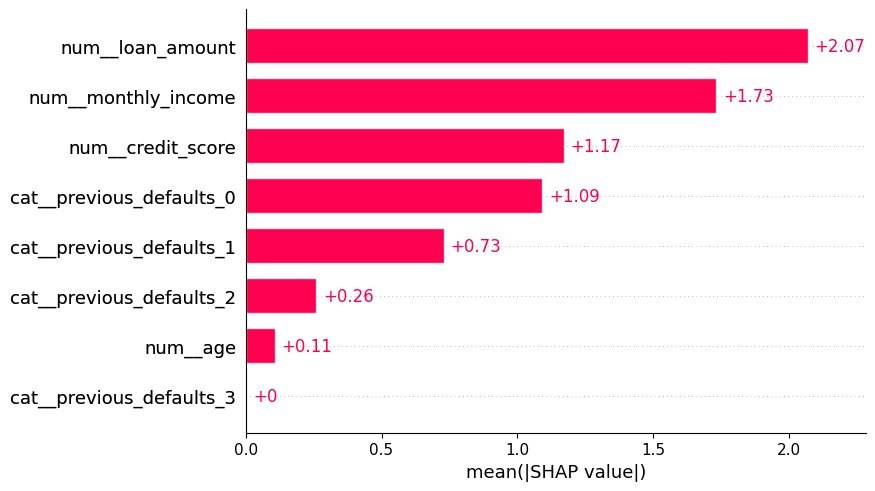

<Figure size 640x480 with 0 Axes>

In [52]:
# Plot summary
shap.plots.bar(shap_values, max_display=10)

# Save to PNG
plt.savefig("shap_summary.png", dpi=300, bbox_inches="tight")

### SHAP Summary: Top Predictive Features

SHAP values indicate that the model relies most heavily on:

- **Loan Amount**: Higher loan values significantly increase default risk.
- **Monthly Income**: Lower income correlates with higher risk.
- **Credit Score**: As expected, lower scores are strong predictors of default.

Additionally, **having zero previous defaults** is a strong protective factor. Interestingly, age has minimal influence, suggesting that default risk is not strongly tied to age in this dataset.

These insights confirm that the model is learning patterns aligned with financial intuition and credit risk behavior.

# Model Usage
Let's try to actually use the model as if it's in the real world. First we simulate an employee input the applicant data that asking for a loan of **IDR 5,000,000**<br>
Then the employee input it in the model and run the program.

In [100]:
# New Applicant data, asking for a loan of IDR 5_000_000
new_applicant = pd.DataFrame([{
    "age": 29,
    "monthly_income": 200_000,
    "loan_amount": 5_000_000,
    "previous_defaults": 0,
    "credit_score": 550
}])

# Predict probability of default
prob = best_model.predict_proba(new_applicant)[:, 1][0]
credit_score_prob = score_card(prob)
decision = "Approve" if credit_score_prob >= 700 else "Reject"

A threshold of 700 was chosen for the generated credit score as it mirrors common industry practices, where scores above 700 are considered ‘good’ or ‘low risk’. This cutoff provides a clear, interpretable decision point for loan approval.

It then give output as a print out or a screen notification saying "approve" or "reject"

In [101]:
# Extract data as dictionary
data_dict = new_applicant.iloc[0].to_dict()

# Create PDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Times", size=12)

# Title
pdf.set_font("Times", 'B', 20)
pdf.cell(200, 10, txt="Loan Approval Decision", ln=True, align="C")
pdf.ln(10)

# Applicant Introduction
pdf.set_font("Times", size=12)
pdf.multi_cell(0, 10, "The applicant with the following data:")

# Table-like data
for key, value in new_applicant.items():
    if key == "loan_amount":
        continue
    if isinstance(value, float):
        value_str = f"{value:,.2f}"
    else:
        value_str = f"{int(value):,}"
    pdf.cell(0, 10, txt=f"  - {key.replace('_', ' ').capitalize()}: {value_str}", ln=True)

pdf.ln(5)
pdf.cell(200, 10, txt=f"Asking for a Loan of IDR {int(data_dict['loan_amount']):,}", ln=True)
pdf.ln(5)

# Decision and reason
pdf.cell(0, 10, txt=f"Based on the applicant data, the loan is:", ln=True, align="C")
pdf.set_font("Times", 'B', 16)
pdf.cell(0, 10, txt=f"{decision.upper()}", ln=True, align="C")
pdf.ln(5)
pdf.set_font("Times", size=12)
pdf.multi_cell(0, 10, f"Reason:\nThe predicted probability of default is {prob:.2%}, resulting in a generated credit score of {credit_score:.0f}. Based on this score and the business threshold, the loan application is {decision.lower()}ed.")

# Save the PDF
pdf.output("decision_slide.pdf")

C:\Users\Affan\AppData\Local\Temp\ipykernel_25632\2279483990.py:25: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  value_str = f"{int(value):,}"


''